In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from dbscan_cluster import run_dbscan
from cluster_utils import cluster_plot, cluster_plot_galactic
import json

from astropy.coordinates import SkyCoord, ICRS
import astropy.units as u
from simbad_download import resolve_name, fetch_object_children, fetch_catalog_id, count_reportings

In [3]:
CLUSTER_NAME: str = 'NGC 188'

In [4]:
gaiadr3 = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}.csv')
normalized = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized.dat')
lit = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_literature.csv')

In [5]:
cp_ra, cp_dec, cp_par, cp_pmra, cp_pmdec, cp_radvel = resolve_name(CLUSTER_NAME)

In [7]:
with open(f"optuna_db/{CLUSTER_NAME}/{CLUSTER_NAME.replace(' ', '_')}_best_params.json", 'r') as f:
    best_params = json.load(f)

In [8]:
best_params

{'best_value': 1.024340676450316,
 'best_params': {'eps': 0.10033850561365287, 'min_samples': 15}}

In [15]:
clustered, _, _ = run_dbscan(normalized, gaiadr3, lit, 0.04, 9, False)

Classified into 167 labels.
Clustered: 624/836
624/836 sources from literature clustered
3170 clustered sources.


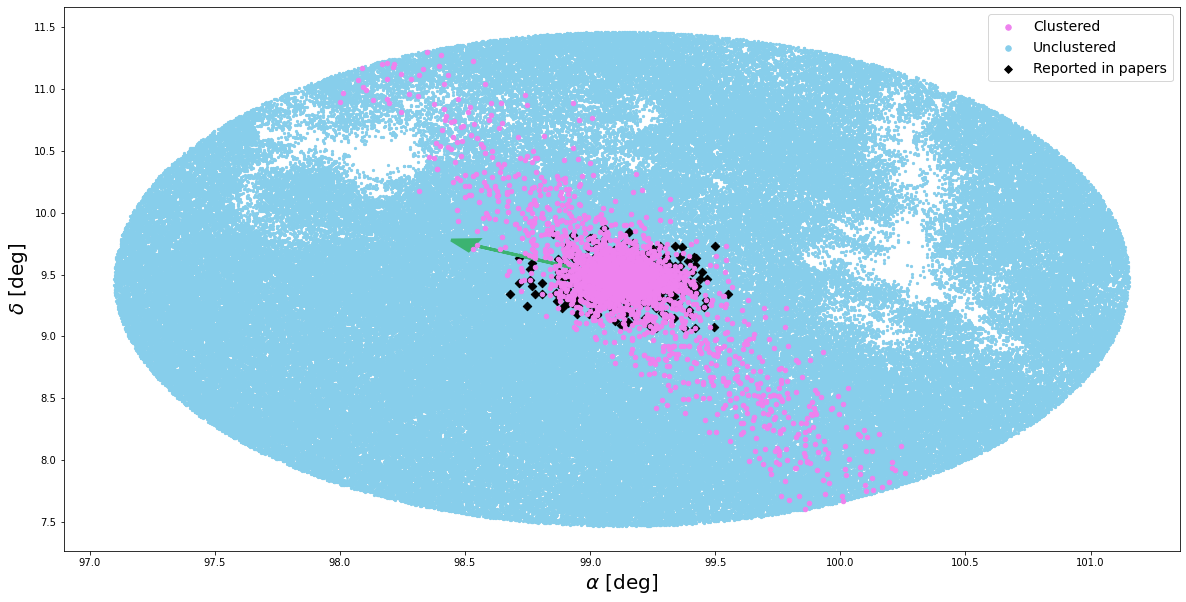

In [17]:
cluster_plot(clustered, gaiadr3, lit)
plt.arrow(cp_ra,
          cp_dec,
          cp_pmra,
          cp_pmdec,
          linewidth=3.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.1)

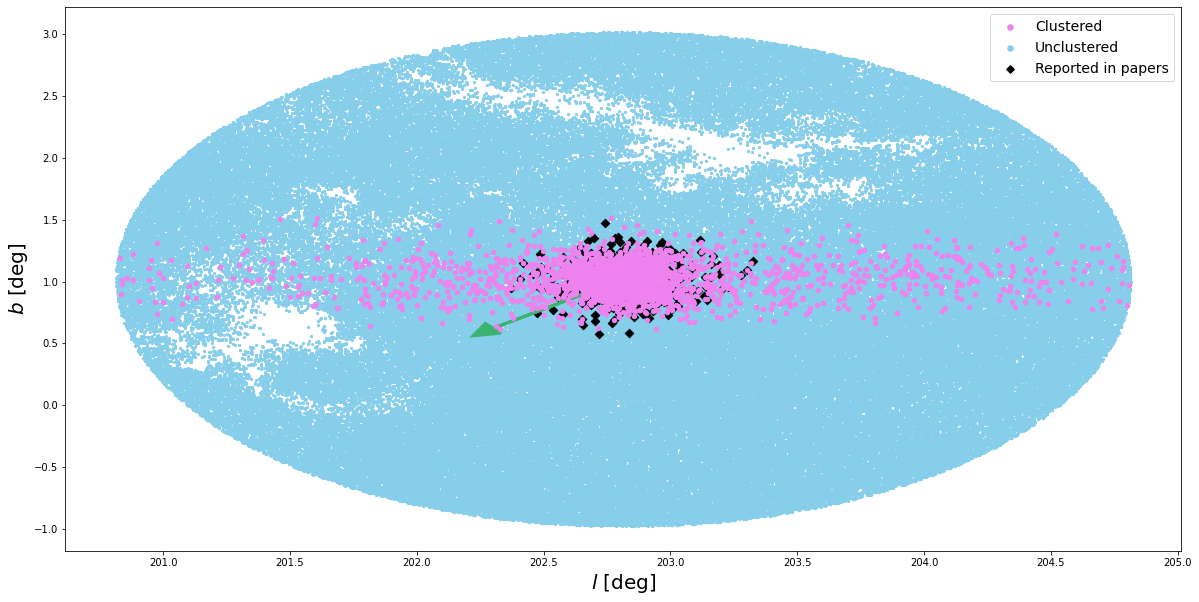

In [18]:
cluster_plot_galactic(clustered, gaiadr3, lit)
plt.arrow(galactic_coords.l.value,
          galactic_coords.b.value,
          galactic_coords.pm_l_cosb.value,
          galactic_coords.pm_b.value,
          linewidth=3.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.1)

In [13]:
a = np.loadtxt('Trumpler 5_isochrone.dat', usecols=(28, 29, 30))

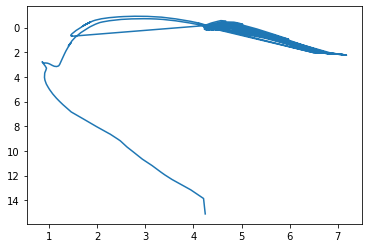

In [14]:
plt.plot(a[:-1, 1]-a[:-1, 2], a[:-1, 0])
plt.gca().invert_yaxis();